# Test Data Preparation and Testing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter
from hampel import hampel
from tqdm.notebook import trange, tqdm

In [2]:
file = 'data_collection/test_3min.xlsx'
df = pd.read_excel(file)
emg_labels = ['emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
df.columns = ['t[s]']+emg_labels
df

,t[s],emg1,emg2,emg3,emg4,emg5,emg6,emg7,emg8
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.001862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
387709,180.485224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
387710,180.485690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
387711,180.486155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
387712,180.486621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


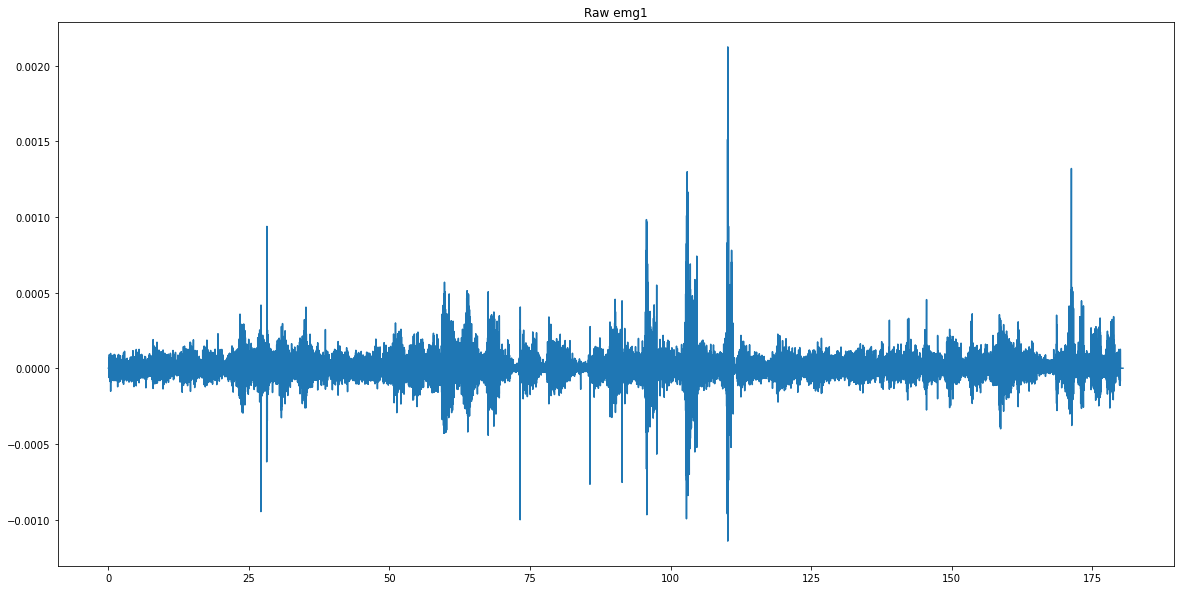

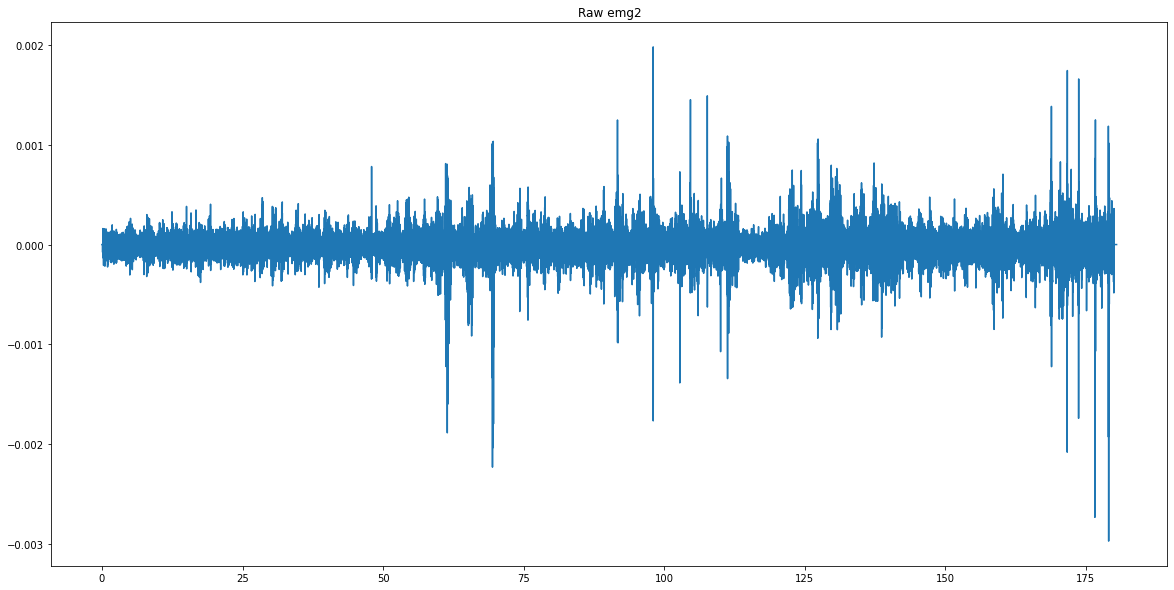

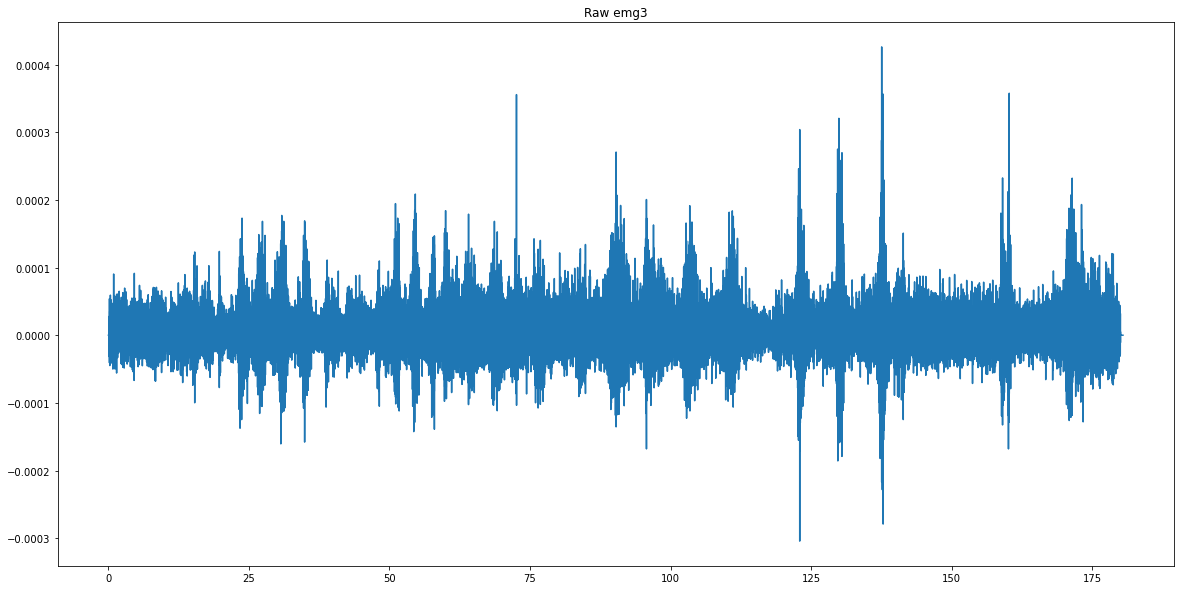

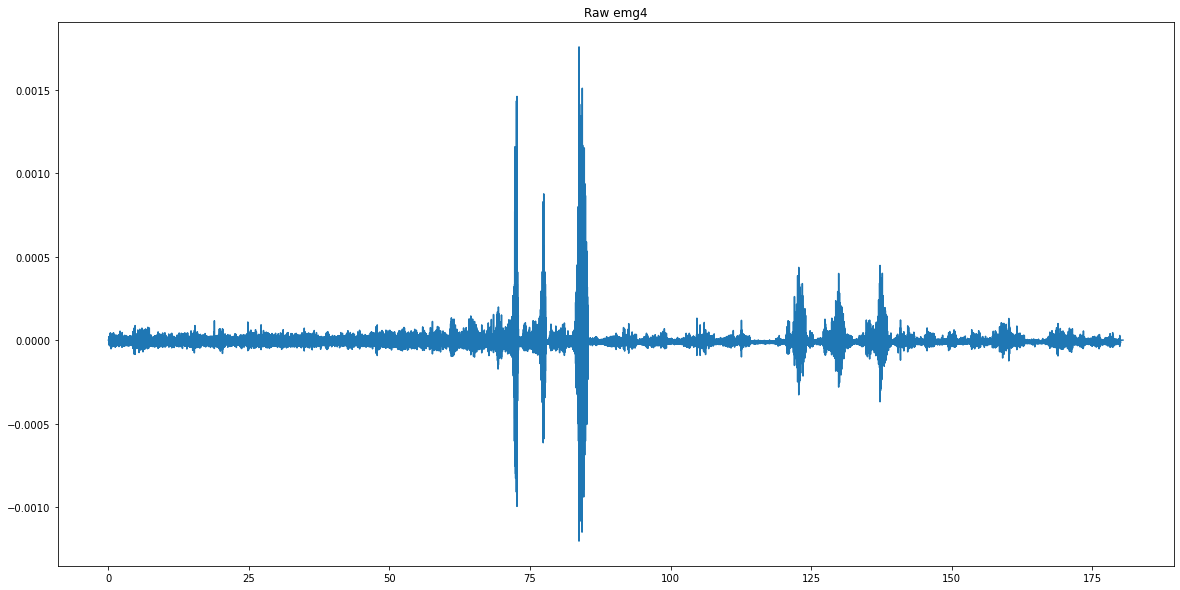

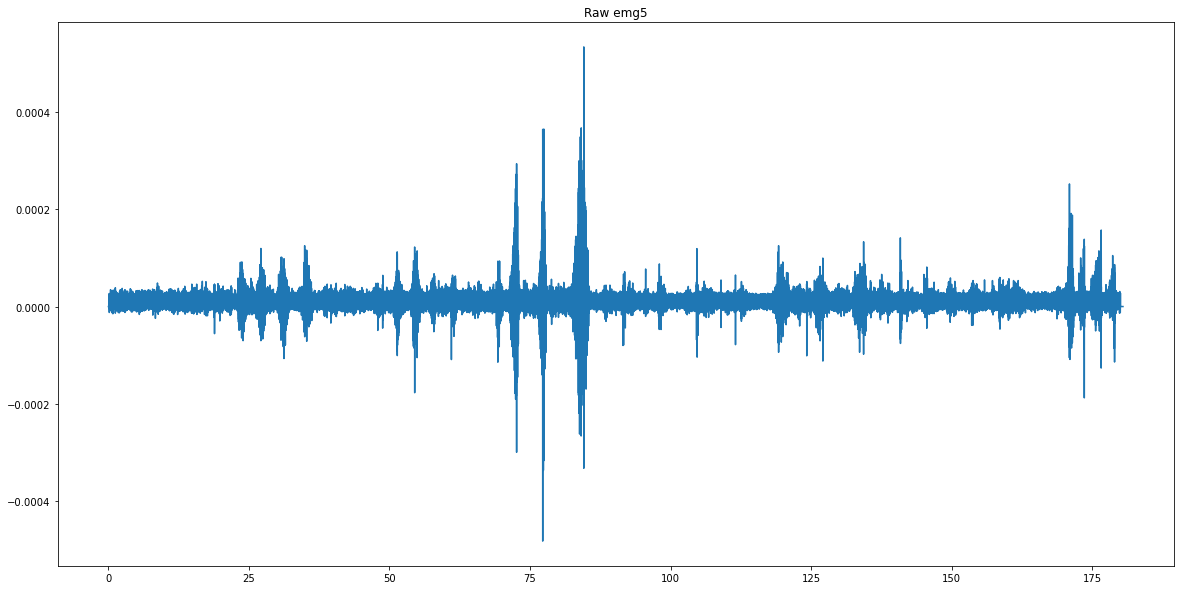

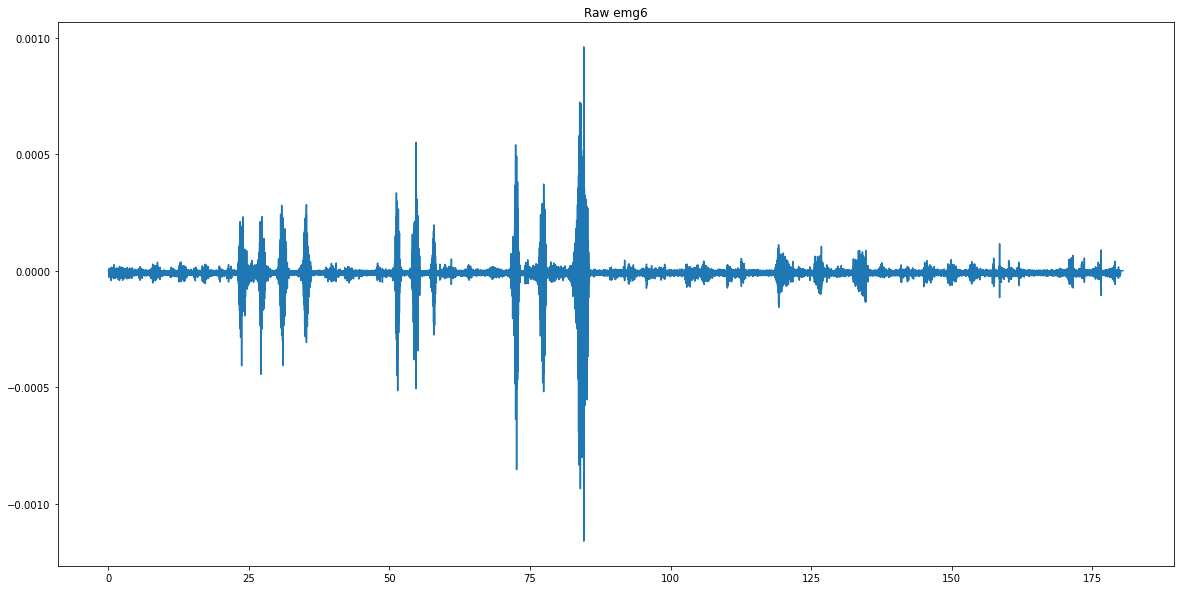

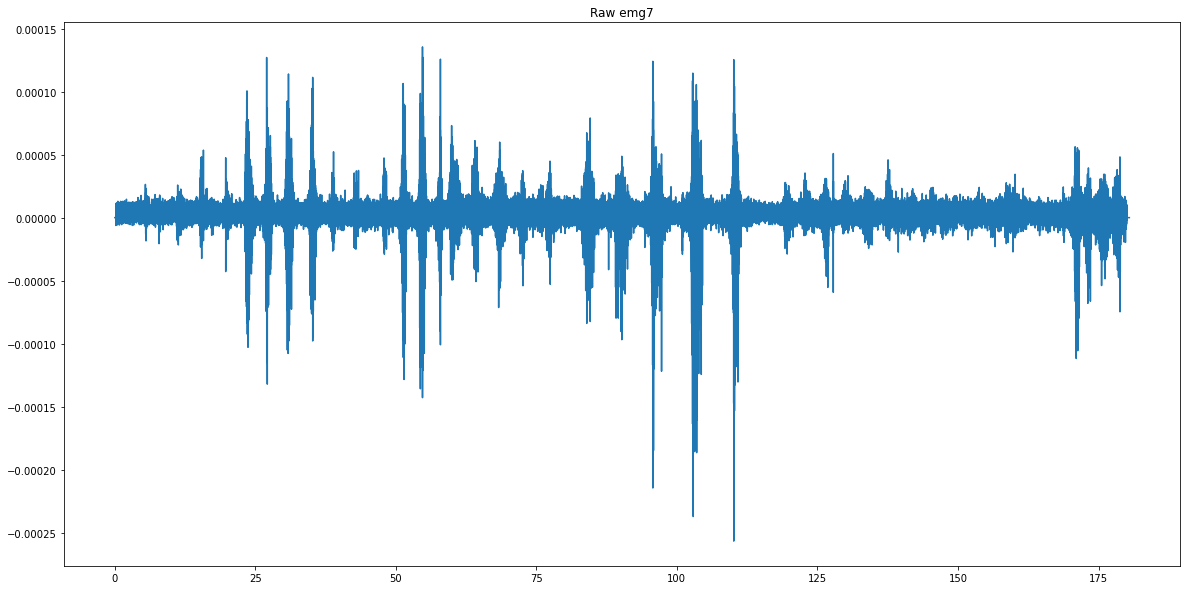

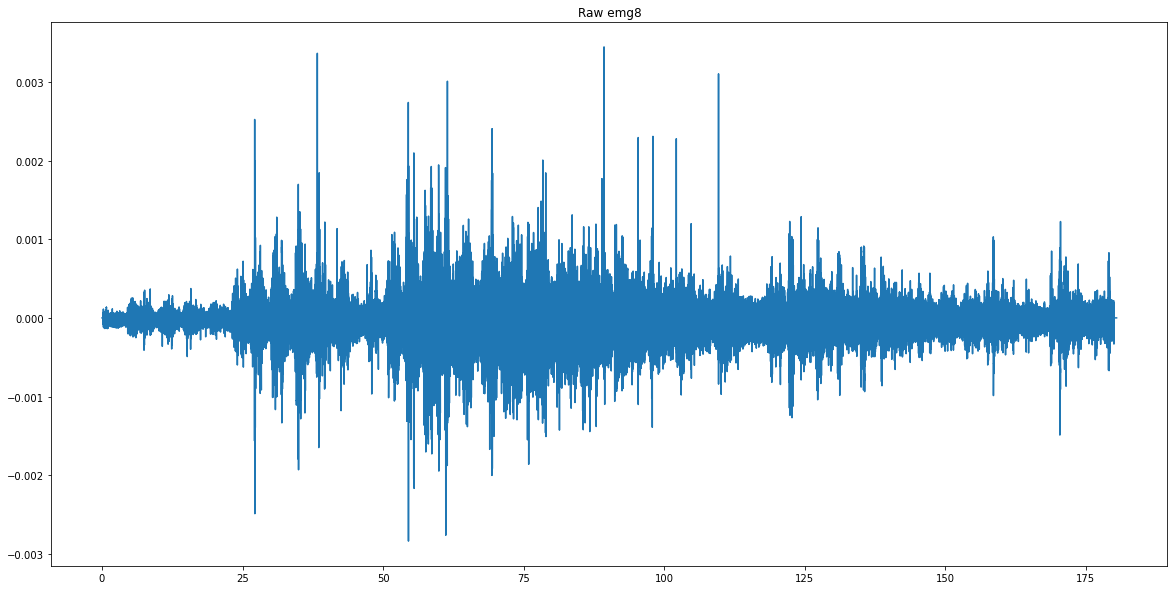

In [20]:
for label in emg_labels:
    plt.figure(figsize=(20,10))
    plt.title('Raw '+label)
    plt.plot(df['t[s]'],df[label])
    plt.show()

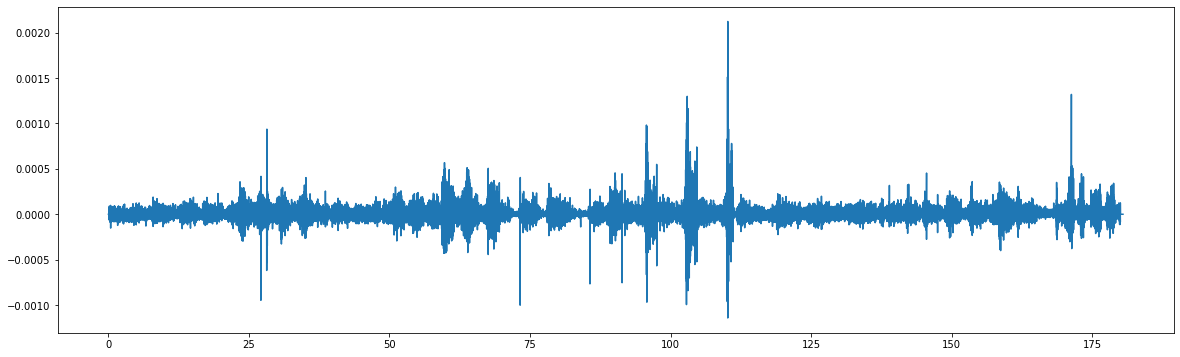

In [8]:
EMG1 = df['emg1']
plt.figure(figsize=(20,6))
plt.plot(df['t[s]'],EMG1)
plt.show()

In [32]:
ham = hampel(EMG1, window_size=50, n=3, imputation=True)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(df['t[s]'],ham)
plt.show()

## Make windowed Data

In [35]:
def make_windowed(data,win_len):
    nb = data.shape[0]
    X = []
    for i in tqdm(range(nb-win_len)):
        X.append(data[i:i+win_len])
    return np.array(X)

In [3]:
emg_df = df[emg_labels]

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=False).fit(emg_df)

In [5]:
print(scaler.mean_)
print(scaler.scale_)
print(scaler.n_features_in_)
print(scaler.n_samples_seen_)
print(scaler.var_)

[ 2.32802954e-08 -1.22729370e-05  2.96584701e-06 -1.21403015e-05
  1.05353684e-05 -9.59993201e-06  3.59069033e-06 -1.16306964e-05]
[5.18101183e-05 1.49465787e-04 2.13536543e-05 3.45215319e-05
 1.48529746e-05 2.63012155e-05 8.86546300e-06 2.78710835e-04]
8
387714
[2.68428836e-09 2.23400214e-08 4.55978550e-10 1.19173617e-09
 2.20610853e-10 6.91753936e-10 7.85964341e-11 7.76797298e-08]


In [6]:
emg_df = scaler.transform(emg_df)

In [8]:
np.save('Myotron_Controll_codes/sim_data/norm_emg_3m',emg_df)

In [40]:
windowed_test = make_windowed(emg_df,250)

In [41]:
np.save('Myotron_Controll_codes/sim_data/test_windowed',windowed_test)

In [2]:
windowed_data = np.load('Myotron_Controll_codes/sim_data/test_windowed.npy')

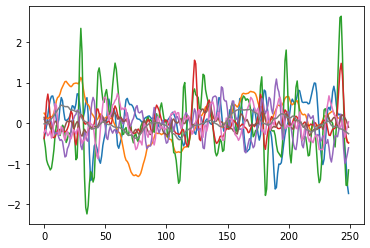

In [3]:
plt.plot(windowed_data[500])
plt.show()

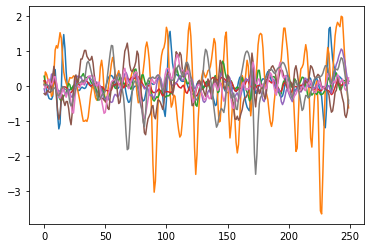

In [4]:
ninapro_data = np.load('prepared_data/X_test_s40.npy')
plt.plot(ninapro_data[500])
plt.show()

In [5]:
from keras.models import load_model
file = 'wrist_model_250_89'
model = load_model(file)

In [6]:
def wrist_classifier(data):
    data = np.array(data) 
    data = np.reshape(data,(1,250,8))
    pred = model.predict(data,batch_size=1)[0]
    return pred

In [37]:
time = 60+41
frame = int(time*(5422/180))
nx = int(windowed_data.shape[0]/180)
ts = time*nx
print('Time - ',time,' frame - ',frame,' T[s] - ',ts)
all_window_ts = windowed_data[ts-nx:ts]

Time -  101  frame -  3042  T[s] -  217352


In [38]:
wrist_moves = ['Suplination - CW (rot axis Mid finger)',
               'Pronation - CCW (rot axis Mid finger)',
               'Suplination - CW (rot axis lit finger)',
               'Pronation - CCW (rot axis lit finger)',
               'Flexion - Bend Towards',' Extension - Bend Backward',
               'Radial - Left - CCW',
               'Radial - Righ - CW',
               'Extension with closed hand']

In [39]:
i = 0
for d in all_window_ts:
    i=i+1
    soft_pred = wrist_classifier(d)
    clf = np.argmax(np.array(soft_pred))
    print('[',i,'] ',wrist_moves[clf],' ',soft_pred[clf]*100)

[ 1 ]  Suplination - CW (rot axis lit finger)   72.32051491737366
[ 2 ]  Suplination - CW (rot axis lit finger)   67.16288328170776
[ 3 ]  Suplination - CW (rot axis lit finger)   55.04976511001587
[ 4 ]  Suplination - CW (rot axis lit finger)   59.83729958534241
[ 5 ]  Suplination - CW (rot axis lit finger)   61.24492883682251
[ 6 ]  Suplination - CW (rot axis lit finger)   73.75648021697998
[ 7 ]  Suplination - CW (rot axis lit finger)   83.71517658233643
[ 8 ]  Suplination - CW (rot axis lit finger)   81.29804730415344
[ 9 ]  Suplination - CW (rot axis lit finger)   74.5591402053833
[ 10 ]  Suplination - CW (rot axis lit finger)   89.54123854637146
[ 11 ]  Suplination - CW (rot axis lit finger)   95.75740098953247
[ 12 ]  Suplination - CW (rot axis lit finger)   94.82524394989014
[ 13 ]  Suplination - CW (rot axis lit finger)   96.75379395484924
[ 14 ]  Suplination - CW (rot axis lit finger)   86.90321445465088
[ 15 ]  Suplination - CW (rot axis lit finger)   76.96548700332642
[ 16 

[ 127 ]  Suplination - CW (rot axis lit finger)   99.95145797729492
[ 128 ]  Suplination - CW (rot axis lit finger)   99.85478520393372
[ 129 ]  Suplination - CW (rot axis lit finger)   99.73834156990051
[ 130 ]  Suplination - CW (rot axis lit finger)   99.49434399604797
[ 131 ]  Suplination - CW (rot axis lit finger)   99.78294968605042
[ 132 ]  Suplination - CW (rot axis lit finger)   99.69237446784973
[ 133 ]  Suplination - CW (rot axis lit finger)   99.55407977104187
[ 134 ]  Suplination - CW (rot axis lit finger)   98.45708012580872
[ 135 ]  Suplination - CW (rot axis lit finger)   99.02788996696472
[ 136 ]  Suplination - CW (rot axis lit finger)   99.18045997619629
[ 137 ]  Suplination - CW (rot axis lit finger)   98.9577054977417
[ 138 ]  Suplination - CW (rot axis lit finger)   99.29206967353821
[ 139 ]  Suplination - CW (rot axis lit finger)   96.99287414550781
[ 140 ]  Suplination - CW (rot axis lit finger)   94.61060762405396
[ 141 ]  Suplination - CW (rot axis lit finger)  

[ 258 ]  Suplination - CW (rot axis lit finger)   95.5286979675293
[ 259 ]  Suplination - CW (rot axis lit finger)   95.22143006324768
[ 260 ]  Suplination - CW (rot axis lit finger)   96.18526101112366
[ 261 ]  Suplination - CW (rot axis lit finger)   97.18989133834839
[ 262 ]  Suplination - CW (rot axis lit finger)   97.30461835861206
[ 263 ]  Suplination - CW (rot axis lit finger)   95.92334628105164
[ 264 ]  Suplination - CW (rot axis lit finger)   91.98272228240967
[ 265 ]  Suplination - CW (rot axis lit finger)   91.01804494857788
[ 266 ]  Suplination - CW (rot axis lit finger)   92.11612939834595
[ 267 ]  Suplination - CW (rot axis lit finger)   93.14318299293518
[ 268 ]  Suplination - CW (rot axis lit finger)   85.49416661262512
[ 269 ]  Suplination - CW (rot axis lit finger)   87.93247938156128
[ 270 ]  Suplination - CW (rot axis lit finger)   67.4590528011322
[ 271 ]  Suplination - CW (rot axis lit finger)   70.53868770599365
[ 272 ]  Suplination - CW (rot axis lit finger)   

[ 382 ]  Suplination - CW (rot axis Mid finger)   99.72903728485107
[ 383 ]  Suplination - CW (rot axis Mid finger)   99.80385899543762
[ 384 ]  Suplination - CW (rot axis Mid finger)   99.15574789047241
[ 385 ]  Suplination - CW (rot axis Mid finger)   98.24442267417908
[ 386 ]  Suplination - CW (rot axis Mid finger)   79.34709787368774
[ 387 ]  Suplination - CW (rot axis Mid finger)   74.72133040428162
[ 388 ]  Suplination - CW (rot axis Mid finger)   65.54600596427917
[ 389 ]  Pronation - CCW (rot axis Mid finger)   53.7025511264801
[ 390 ]  Suplination - CW (rot axis Mid finger)   51.81635618209839
[ 391 ]  Suplination - CW (rot axis Mid finger)   89.62962031364441
[ 392 ]  Suplination - CW (rot axis Mid finger)   91.11208915710449
[ 393 ]  Suplination - CW (rot axis Mid finger)   80.44445514678955
[ 394 ]  Suplination - CW (rot axis Mid finger)   85.72463393211365
[ 395 ]  Suplination - CW (rot axis Mid finger)   76.11681818962097
[ 396 ]  Suplination - CW (rot axis Mid finger)   

[ 506 ]  Suplination - CW (rot axis Mid finger)   96.17287516593933
[ 507 ]  Suplination - CW (rot axis Mid finger)   96.77849411964417
[ 508 ]  Suplination - CW (rot axis Mid finger)   98.05032014846802
[ 509 ]  Suplination - CW (rot axis Mid finger)   96.74080610275269
[ 510 ]  Suplination - CW (rot axis Mid finger)   90.3994619846344
[ 511 ]  Suplination - CW (rot axis Mid finger)   81.80978298187256
[ 512 ]  Suplination - CW (rot axis Mid finger)   91.84865355491638
[ 513 ]  Suplination - CW (rot axis Mid finger)   89.45919871330261
[ 514 ]  Suplination - CW (rot axis Mid finger)   86.32815480232239
[ 515 ]  Suplination - CW (rot axis Mid finger)   90.6972348690033
[ 516 ]  Suplination - CW (rot axis Mid finger)   93.36141347885132
[ 517 ]  Suplination - CW (rot axis Mid finger)   94.74512934684753
[ 518 ]  Suplination - CW (rot axis Mid finger)   94.25860047340393
[ 519 ]  Suplination - CW (rot axis Mid finger)   93.23281049728394
[ 520 ]  Suplination - CW (rot axis Mid finger)   

[ 632 ]  Pronation - CCW (rot axis lit finger)   61.329907178878784
[ 633 ]  Pronation - CCW (rot axis lit finger)   69.99270915985107
[ 634 ]  Pronation - CCW (rot axis lit finger)   71.13568186759949
[ 635 ]  Pronation - CCW (rot axis lit finger)   90.48318862915039
[ 636 ]  Pronation - CCW (rot axis lit finger)   96.56336307525635
[ 637 ]  Pronation - CCW (rot axis lit finger)   97.99842238426208
[ 638 ]  Pronation - CCW (rot axis lit finger)   92.61366724967957
[ 639 ]  Pronation - CCW (rot axis lit finger)   94.72858309745789
[ 640 ]  Pronation - CCW (rot axis lit finger)   96.65002226829529
[ 641 ]  Pronation - CCW (rot axis lit finger)   98.28232526779175
[ 642 ]  Pronation - CCW (rot axis lit finger)   98.4539806842804
[ 643 ]  Pronation - CCW (rot axis lit finger)   99.46895837783813
[ 644 ]  Pronation - CCW (rot axis lit finger)   99.54596161842346
[ 645 ]  Pronation - CCW (rot axis lit finger)   99.87143278121948
[ 646 ]  Pronation - CCW (rot axis lit finger)   99.4681894779

[ 756 ]  Suplination - CW (rot axis Mid finger)   99.65946078300476
[ 757 ]  Suplination - CW (rot axis Mid finger)   99.81712102890015
[ 758 ]  Suplination - CW (rot axis Mid finger)   99.94315505027771
[ 759 ]  Suplination - CW (rot axis Mid finger)   99.94994401931763
[ 760 ]  Suplination - CW (rot axis Mid finger)   99.94927644729614
[ 761 ]  Suplination - CW (rot axis Mid finger)   99.95958209037781
[ 762 ]  Suplination - CW (rot axis Mid finger)   99.94625449180603
[ 763 ]  Suplination - CW (rot axis Mid finger)   99.93921518325806
[ 764 ]  Suplination - CW (rot axis Mid finger)   99.92019534111023
[ 765 ]  Suplination - CW (rot axis Mid finger)   99.95549321174622
[ 766 ]  Suplination - CW (rot axis Mid finger)   99.92365837097168
[ 767 ]  Suplination - CW (rot axis Mid finger)   99.97888207435608
[ 768 ]  Suplination - CW (rot axis Mid finger)   99.9744713306427
[ 769 ]  Suplination - CW (rot axis Mid finger)   99.98553991317749
[ 770 ]  Suplination - CW (rot axis Mid finger)  

[ 878 ]  Suplination - CW (rot axis Mid finger)   99.97028708457947
[ 879 ]  Suplination - CW (rot axis Mid finger)   99.88260865211487
[ 880 ]  Suplination - CW (rot axis Mid finger)   99.84595775604248
[ 881 ]  Suplination - CW (rot axis Mid finger)   99.81738328933716
[ 882 ]  Suplination - CW (rot axis Mid finger)   99.4312047958374
[ 883 ]  Suplination - CW (rot axis Mid finger)   99.73604083061218
[ 884 ]  Suplination - CW (rot axis Mid finger)   99.56205487251282
[ 885 ]  Suplination - CW (rot axis Mid finger)   99.64171648025513
[ 886 ]  Suplination - CW (rot axis Mid finger)   98.95786643028259
[ 887 ]  Suplination - CW (rot axis Mid finger)   99.05810952186584
[ 888 ]  Suplination - CW (rot axis Mid finger)   97.6435124874115
[ 889 ]  Suplination - CW (rot axis Mid finger)   98.37324023246765
[ 890 ]  Suplination - CW (rot axis Mid finger)   97.51249551773071
[ 891 ]  Suplination - CW (rot axis Mid finger)   93.66052150726318
[ 892 ]  Suplination - CW (rot axis Mid finger)   

[ 1005 ]  Pronation - CCW (rot axis Mid finger)   51.428890228271484
[ 1006 ]  Pronation - CCW (rot axis lit finger)   69.50120329856873
[ 1007 ]  Pronation - CCW (rot axis lit finger)   64.51319456100464
[ 1008 ]  Pronation - CCW (rot axis lit finger)   81.13413453102112
[ 1009 ]  Pronation - CCW (rot axis lit finger)   76.24322772026062
[ 1010 ]  Pronation - CCW (rot axis lit finger)   80.20113706588745
[ 1011 ]  Pronation - CCW (rot axis Mid finger)   68.56603622436523
[ 1012 ]  Pronation - CCW (rot axis lit finger)   68.51958632469177
[ 1013 ]  Pronation - CCW (rot axis lit finger)   94.93054747581482
[ 1014 ]  Pronation - CCW (rot axis lit finger)   86.55189275741577
[ 1015 ]  Pronation - CCW (rot axis lit finger)   59.152328968048096
[ 1016 ]  Pronation - CCW (rot axis lit finger)   73.4498679637909
[ 1017 ]  Pronation - CCW (rot axis lit finger)   71.93383574485779
[ 1018 ]  Pronation - CCW (rot axis lit finger)   53.1880259513855
[ 1019 ]  Pronation - CCW (rot axis lit finger) 

[ 1128 ]  Suplination - CW (rot axis Mid finger)   99.30204749107361
[ 1129 ]  Suplination - CW (rot axis Mid finger)   99.53761100769043
[ 1130 ]  Suplination - CW (rot axis Mid finger)   99.74067807197571
[ 1131 ]  Suplination - CW (rot axis Mid finger)   99.67095851898193
[ 1132 ]  Suplination - CW (rot axis Mid finger)   99.75868463516235
[ 1133 ]  Suplination - CW (rot axis Mid finger)   99.86715316772461
[ 1134 ]  Suplination - CW (rot axis Mid finger)   99.95129108428955
[ 1135 ]  Suplination - CW (rot axis Mid finger)   99.78546500205994
[ 1136 ]  Suplination - CW (rot axis Mid finger)   99.46213960647583
[ 1137 ]  Suplination - CW (rot axis Mid finger)   99.72391128540039
[ 1138 ]  Suplination - CW (rot axis Mid finger)   99.66303706169128
[ 1139 ]  Suplination - CW (rot axis Mid finger)   99.51059818267822
[ 1140 ]  Suplination - CW (rot axis Mid finger)   99.88937973976135
[ 1141 ]  Suplination - CW (rot axis Mid finger)   99.95705485343933
[ 1142 ]  Suplination - CW (rot ax

[ 1249 ]  Suplination - CW (rot axis Mid finger)   67.64177083969116
[ 1250 ]  Suplination - CW (rot axis Mid finger)   90.90564846992493
[ 1251 ]  Suplination - CW (rot axis Mid finger)   93.61633658409119
[ 1252 ]  Suplination - CW (rot axis Mid finger)   93.55298280715942
[ 1253 ]  Suplination - CW (rot axis Mid finger)   90.41480422019958
[ 1254 ]  Suplination - CW (rot axis Mid finger)   65.03525972366333
[ 1255 ]  Suplination - CW (rot axis Mid finger)   82.63159394264221
[ 1256 ]  Suplination - CW (rot axis Mid finger)   85.38942337036133
[ 1257 ]  Suplination - CW (rot axis Mid finger)   85.81978678703308
[ 1258 ]  Suplination - CW (rot axis Mid finger)   76.84407234191895
[ 1259 ]  Suplination - CW (rot axis Mid finger)   72.44032621383667
[ 1260 ]  Pronation - CCW (rot axis lit finger)   54.289811849594116
[ 1261 ]  Pronation - CCW (rot axis lit finger)   56.20887279510498
[ 1262 ]  Pronation - CCW (rot axis lit finger)   51.95243954658508
[ 1263 ]  Suplination - CW (rot axis

[ 1373 ]  Pronation - CCW (rot axis lit finger)   61.17314100265503
[ 1374 ]  Suplination - CW (rot axis Mid finger)   61.46303415298462
[ 1375 ]  Suplination - CW (rot axis Mid finger)   82.99209475517273
[ 1376 ]  Suplination - CW (rot axis Mid finger)   94.7145164012909
[ 1377 ]  Suplination - CW (rot axis Mid finger)   96.0958480834961
[ 1378 ]  Suplination - CW (rot axis Mid finger)   85.27441620826721
[ 1379 ]  Suplination - CW (rot axis Mid finger)   90.00203609466553
[ 1380 ]  Suplination - CW (rot axis Mid finger)   79.9319863319397
[ 1381 ]  Suplination - CW (rot axis Mid finger)   92.03214645385742
[ 1382 ]  Suplination - CW (rot axis Mid finger)   82.27541446685791
[ 1383 ]  Suplination - CW (rot axis Mid finger)   82.78385400772095
[ 1384 ]  Suplination - CW (rot axis Mid finger)   74.69748854637146
[ 1385 ]  Suplination - CW (rot axis Mid finger)   82.53094553947449
[ 1386 ]  Pronation - CCW (rot axis lit finger)   76.49309635162354
[ 1387 ]  Suplination - CW (rot axis Mi

[ 1497 ]  Suplination - CW (rot axis Mid finger)   86.74149513244629
[ 1498 ]  Suplination - CW (rot axis Mid finger)   84.07686948776245
[ 1499 ]  Suplination - CW (rot axis Mid finger)   90.1782214641571
[ 1500 ]  Suplination - CW (rot axis Mid finger)   79.2414128780365
[ 1501 ]  Suplination - CW (rot axis Mid finger)   85.6618344783783
[ 1502 ]  Suplination - CW (rot axis Mid finger)   90.07900953292847
[ 1503 ]  Suplination - CW (rot axis Mid finger)   92.88947582244873
[ 1504 ]  Suplination - CW (rot axis Mid finger)   86.1883282661438
[ 1505 ]  Suplination - CW (rot axis Mid finger)   86.37117743492126
[ 1506 ]  Suplination - CW (rot axis Mid finger)   70.7339882850647
[ 1507 ]  Suplination - CW (rot axis Mid finger)   91.53163433074951
[ 1508 ]  Suplination - CW (rot axis Mid finger)   85.61820387840271
[ 1509 ]  Suplination - CW (rot axis Mid finger)   87.08939552307129
[ 1510 ]  Suplination - CW (rot axis Mid finger)   89.03042674064636
[ 1511 ]  Suplination - CW (rot axis Mi

[ 1622 ]  Pronation - CCW (rot axis lit finger)   99.88899827003479
[ 1623 ]  Pronation - CCW (rot axis lit finger)   99.91809725761414
[ 1624 ]  Pronation - CCW (rot axis lit finger)   99.91845488548279
[ 1625 ]  Pronation - CCW (rot axis lit finger)   99.82329607009888
[ 1626 ]  Pronation - CCW (rot axis lit finger)   99.80080723762512
[ 1627 ]  Pronation - CCW (rot axis lit finger)   99.87950325012207
[ 1628 ]  Pronation - CCW (rot axis lit finger)   99.80036616325378
[ 1629 ]  Pronation - CCW (rot axis lit finger)   99.71542358398438
[ 1630 ]  Pronation - CCW (rot axis lit finger)   99.38536882400513
[ 1631 ]  Pronation - CCW (rot axis lit finger)   99.51837658882141
[ 1632 ]  Pronation - CCW (rot axis lit finger)   99.61603879928589
[ 1633 ]  Pronation - CCW (rot axis lit finger)   99.5771586894989
[ 1634 ]  Pronation - CCW (rot axis lit finger)   99.77834820747375
[ 1635 ]  Pronation - CCW (rot axis lit finger)   99.70458149909973
[ 1636 ]  Pronation - CCW (rot axis lit finger)  

[ 1746 ]  Pronation - CCW (rot axis Mid finger)   80.57483434677124
[ 1747 ]  Pronation - CCW (rot axis Mid finger)   52.54262685775757
[ 1748 ]  Pronation - CCW (rot axis Mid finger)   56.652623414993286
[ 1749 ]  Pronation - CCW (rot axis Mid finger)   71.27791047096252
[ 1750 ]  Pronation - CCW (rot axis Mid finger)   73.18974733352661
[ 1751 ]  Pronation - CCW (rot axis Mid finger)   48.89122545719147
[ 1752 ]  Pronation - CCW (rot axis lit finger)   70.87305784225464
[ 1753 ]  Pronation - CCW (rot axis Mid finger)   56.38416409492493
[ 1754 ]  Pronation - CCW (rot axis Mid finger)   57.185256481170654
[ 1755 ]  Pronation - CCW (rot axis Mid finger)   83.05454850196838
[ 1756 ]  Pronation - CCW (rot axis Mid finger)   87.58186101913452
[ 1757 ]  Pronation - CCW (rot axis Mid finger)   86.82255744934082
[ 1758 ]  Pronation - CCW (rot axis Mid finger)   91.46220684051514
[ 1759 ]  Pronation - CCW (rot axis Mid finger)   84.73790884017944
[ 1760 ]  Pronation - CCW (rot axis Mid finger

[ 1871 ]  Suplination - CW (rot axis Mid finger)   64.93358612060547
[ 1872 ]  Suplination - CW (rot axis Mid finger)   60.92895865440369
[ 1873 ]  Suplination - CW (rot axis Mid finger)   53.07353734970093
[ 1874 ]  Suplination - CW (rot axis Mid finger)   87.28171586990356
[ 1875 ]  Suplination - CW (rot axis Mid finger)   83.30451250076294
[ 1876 ]  Suplination - CW (rot axis Mid finger)   75.15578866004944
[ 1877 ]  Suplination - CW (rot axis Mid finger)   76.50958895683289
[ 1878 ]  Suplination - CW (rot axis Mid finger)   51.85741186141968
[ 1879 ]  Suplination - CW (rot axis Mid finger)   86.08111143112183
[ 1880 ]  Suplination - CW (rot axis Mid finger)   90.46362638473511
[ 1881 ]  Suplination - CW (rot axis Mid finger)   56.338006258010864
[ 1882 ]  Suplination - CW (rot axis Mid finger)   96.15801572799683
[ 1883 ]  Suplination - CW (rot axis Mid finger)   86.23281121253967
[ 1884 ]  Suplination - CW (rot axis Mid finger)   83.06807279586792
[ 1885 ]  Suplination - CW (rot a

[ 1995 ]  Suplination - CW (rot axis lit finger)   99.5241641998291
[ 1996 ]  Suplination - CW (rot axis lit finger)   99.25262928009033
[ 1997 ]  Suplination - CW (rot axis lit finger)   99.51453804969788
[ 1998 ]  Suplination - CW (rot axis lit finger)   99.26159381866455
[ 1999 ]  Suplination - CW (rot axis lit finger)   99.45172667503357
[ 2000 ]  Suplination - CW (rot axis lit finger)   99.17348623275757
[ 2001 ]  Suplination - CW (rot axis lit finger)   98.81689548492432
[ 2002 ]  Suplination - CW (rot axis lit finger)   98.26244711875916
[ 2003 ]  Suplination - CW (rot axis lit finger)   98.87449145317078
[ 2004 ]  Suplination - CW (rot axis lit finger)   98.22439551353455
[ 2005 ]  Suplination - CW (rot axis lit finger)   98.40659499168396
[ 2006 ]  Suplination - CW (rot axis lit finger)   98.56963157653809
[ 2007 ]  Suplination - CW (rot axis lit finger)   95.27928233146667
[ 2008 ]  Suplination - CW (rot axis lit finger)   95.37898898124695
[ 2009 ]  Suplination - CW (rot axi

[ 2124 ]  Suplination - CW (rot axis lit finger)   75.31206607818604
[ 2125 ]  Radial - Righ - CW   56.818002462387085
[ 2126 ]  Suplination - CW (rot axis lit finger)   54.95075583457947
[ 2127 ]  Radial - Righ - CW   61.41188144683838
[ 2128 ]  Suplination - CW (rot axis lit finger)   54.870569705963135
[ 2129 ]  Suplination - CW (rot axis lit finger)   62.59715557098389
[ 2130 ]  Suplination - CW (rot axis lit finger)   52.11842060089111
[ 2131 ]  Radial - Righ - CW   54.3761670589447
[ 2132 ]  Suplination - CW (rot axis lit finger)   73.12036752700806
[ 2133 ]  Suplination - CW (rot axis lit finger)   91.86052083969116
[ 2134 ]  Suplination - CW (rot axis lit finger)   93.6090350151062
[ 2135 ]  Suplination - CW (rot axis lit finger)   84.09700393676758
[ 2136 ]  Suplination - CW (rot axis lit finger)   94.07788515090942
[ 2137 ]  Suplination - CW (rot axis lit finger)   95.26104927062988
[ 2138 ]  Suplination - CW (rot axis lit finger)   94.49247121810913
[ 2139 ]  Suplination - C

## Pred Test Bench

In [1]:
from keras.models import load_model
file = 'grasp_model_250_92'
model = load_model(file)

In [4]:
windowed_data = np.load('Myotron_Controll_codes/sim_data/test_windowed.npy')

In [5]:
grasp_pred = model.predict(windowed_data)
grasp_pred.shape

(387464, 2)